# Study Bayes

### Chapters 8 & 18 
- world cup 

#### Not working:
- empiricaldist
- prior (is part of empiricladist?)
- utils

https://stackoverflow.com/questions/27064348/no-module-named-utils-error-on-compiling-py-file

In [1]:
!pip install empiricaldist

In [2]:
import pandas as pd
import numpy as np
import scipy as scipy
from scipy import linalg, optimize
from scipy.stats import poisson
from scipy.stats import rv_continuous
import matplotlib.pyplot as plt
from empiricaldist import Pmf

In [3]:
df = pd.read_csv('./wc_goals.csv')

In [4]:
df.head()

,year,goals_per_game
0,1930,3.89
1,1934,4.12
2,1938,4.67
3,1950,4.00
4,1954,5.38


### Distribution of goals from international goals database

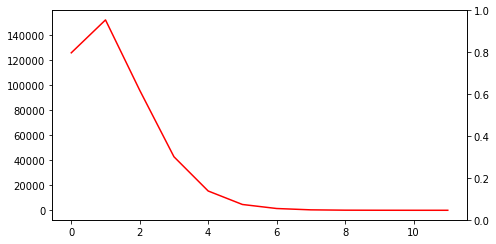

In [5]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig, ax1 = plt.subplots()
ax1.plot([125636, 151877, 95731, 42700, 15384, 4631, 1415, 347, 78, 26, 6, 1], color='red')
ax2 = ax1.twinx()
# ax2.plot([11, 12, 31, 41, 15], color='blue')
fig.tight_layout()
plt.show()

In [6]:
lam = 1.4
dist = poisson(lam)
type(dist)
scipy.stats._distn_infrastructure.rv_frozen

scipy.stats._distn_infrastructure.rv_frozen

In [7]:
k = 4
dist.pmf(k)

0.039471954028253146

In [8]:
def make_poisson_pmf(lam, qs):
# """Make a Pmf of a Poisson distribution."""
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [9]:
lam = 1.4
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)

In [10]:
from scipy.stats import gamma
alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)

In [11]:
prior = Pmf(ps, qs)
prior.normalize()

9.889360237140306

In [12]:
lam = 1.4
k = 4
poisson(lam).pmf(4)

0.039471954028253146

In [13]:
lams = prior.qs
k = 4
likelihood = poisson(lams).pmf(k)

In [14]:
def update_poisson(pmf, data):
# """Update Pmf with a Poisson likelihood."""
    k = data
    lams = pmf.qs
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood
    pmf.normalize()


In [15]:
france = prior.copy()
update_poisson(france, 4)

In [16]:
croatia = prior.copy()
update_poisson(croatia, 2)

In [17]:
def prob_gt(pmf1, pmf2):
#     """Compute the probability of superiority."""
    total = 0
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            if q1 > q2:
                total += p1 * p2
    return total

In [18]:
prob_gt(france, croatia)

0.7499366290930155

In [19]:
Pmf.prob_gt(france, croatia)

0.7499366290930174

In [20]:
pmf_seq = [make_poisson_pmf(lam, goals)
for lam in prior.qs]

In [21]:
from utils import make_mixture

In [22]:
pred_france = make_mixture(france, pmf_seq)

In [23]:
pred_croatia = make_mixture(croatia, pmf_seq)

In [24]:
win = Pmf.prob_gt(pred_france, pred_croatia)
win

0.5703522415934519

In [25]:
lose = Pmf.prob_lt(pred_france, pred_croatia)
lose

0.26443376257235873

In [26]:
tie = Pmf.prob_eq(pred_france, pred_croatia)
tie

0.16521399583418947

In [27]:
win + tie/2

0.6529592395105466

In [28]:
def expo_pdf(t, lam):
# """Compute the PDF of the exponential distribution."""
    return lam * np.exp(-lam * t)


In [29]:
lam = 1.4
qs = np.linspace(0, 4, 101)
ps = expo_pdf(qs, lam)
pmf_time = Pmf(ps, qs)
pmf_time.normalize()

25.616650745459093

# Chapter 18

In [30]:
from scipy.stats import gamma

In [31]:
alpha = 1.4 
dist = gamma(alpha)

In [32]:
import numpy as np
from utils import pmf_from_dist

In [33]:
lams = np.linspace(0, 10, 101)
prior = pmf_from_dist(dist, lams)

In [34]:
from scipy.stats import poisson

k = 4
likelihood = poisson(lams).pmf(k)

In [35]:
posterior = prior * likelihood
posterior.normalize()

0.05015532557804499

In [36]:
def make_gamma_dist(alpha, beta):
#     make a gamma object
    dist = gamma(alpha, scale=1/beta)
    dist.alpha = alpha
    dist.beta = beta
    return dist

In [37]:
alpha = 1.4
beta = 1

In [38]:
prior_gamma = make_gamma_dist(alpha, beta)
prior_gamma.mean()

1.4

In [39]:
def update_gamma(prior, data):
#     update a gamma prior
    k, t = data
    alpha = prior.alpha + k
    beta = prior.beta + t
    return make_gamma_dist(alpha, beta)

In [40]:
data = 4, 1
posterior_gamma = update_gamma(prior_gamma, data)

In [41]:
posterior_conjugate = pmf_from_dist(posterior_gamma, lams)

# Chapter 19

In [42]:
prior_dist = gamma(alpha)

In [43]:
prior_pmf = pmf_from_dist(prior_dist, lams)

In [44]:
lams = np.linspace(0, 10, 101)
prior_omf = pmf_from_dist(prior_dist, lams)

In [45]:
from scipy.stats import poisson

data = 4

In [46]:
likelihood = poisson.pmf(data, lams)

In [47]:
posterior = prior_pmf * likelihood
posterior.normalize()

0.05015532557804499

In [48]:
sample_prior = prior_dist.rvs(1000)

In [49]:
from scipy.stats import poisson

sample_prior_pred = poisson.rvs(sample_prior)

In [50]:
from empiricaldist import Pmf

In [51]:
pmf_prior_pred = Pmf.from_seq(sample_prior_pred)

In [52]:
import pymc3 as pm

In [53]:
with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam)

In [54]:
with model:
    trace = pm.sample_prior_predictive(1000)

In [55]:
sample_prior_pymc = trace['lam']
sample_prior_pymc.shape

(1000,)

In [56]:
sample_prior_pred_pymc = trace['goals']
sample_prior_pred_pymc.shape

(1000,)

In [57]:
with pm.Model() as model:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam)

In [58]:
with pm.Model() as model2:
    lam = pm.Gamma('lam', alpha=1.4, beta=1.0)
    goals = pm.Poisson('goals', lam, observed=4)

In [59]:
options = dict(return_inferencedata=False)

with model2: 
    trace2 = pm.sample(500, **options)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 31 seconds.


In [60]:
sample_post_pymc = trace2['lam']

In [61]:
with model2:
    post_pred = pm.sample_posterior_predictive(trace2)

In [62]:
sample_post_pred_pymc = post_pred['goals']

In [63]:
sample_post = posterior.sample(1000)
sample_post_pred = poisson(sample_post).rvs()